# nn

> Lightweight neural network implementation on top of Value autograd framework

In [1]:
#| default_exp nn

In [2]:
#| hide
from nbdev.showdoc import *

In [3]:
#| export
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import math
from minion.core import Value
import random
from typing import List

In [4]:
#| hide
from minion.utils import draw_dot
from IPython.display import SVG, display

In [5]:
%matplotlib inline

In [43]:
#| export 

class Module(object):
    # def __init__(self) -> None:
    #     pass

    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0.0

    def num_params(self):
        return len(self.parameters())
    
    def parameters(self):
        pass
    # def __repr__(self) -> str:
    #     return "This is a minion module"

In [44]:
Module()

## Neuron Implementation

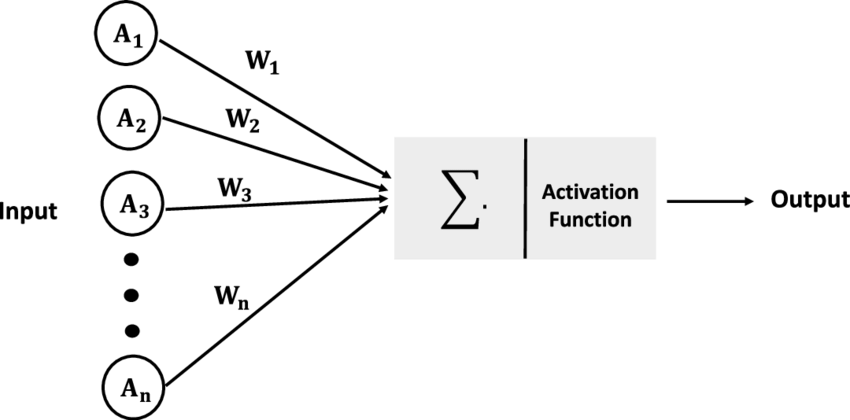

In [45]:
#| export
class Neuron(Module):
    def __init__(self, nin) -> None:
        super().__init__()
        # self.weights = [Value(random.random()) for _ in range(nin)]
        # self.bias = Value(random.random())
        self.weights = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.bias = Value(random.uniform(-1,1))

    def __call__(self, xs) -> Value:
        out = sum((w*x for w,x in zip(self.weights, xs)), self.bias)
        return out.tanh()
    
    def parameters(self):
        return self.weights + [self.bias]


In [46]:
xs = [1, 2, 3, 4]

n = Neuron(len(xs))
n(xs)


Value(data=-0.9999816874198546)

In [47]:
n.parameters()

[Value(data=0.2996475661487965),
 Value(data=-0.6267630844346634),
 Value(data=-0.9246264014404468),
 Value(data=-0.4674702685842562),
 Value(data=-0.20289127806601925)]

## Layer Implementation

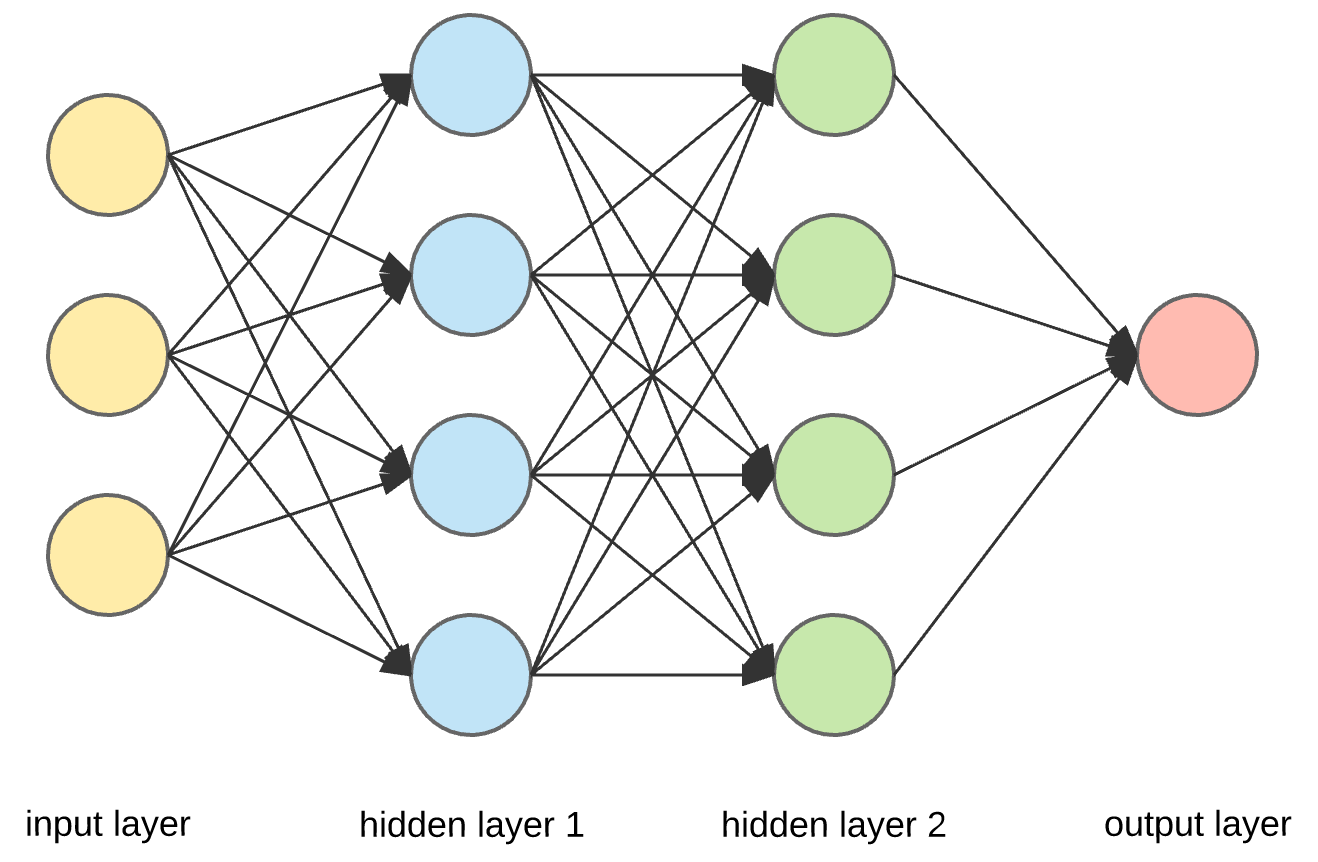

In [48]:
#| export
class Layer(Module):

    def __init__(self, nin, nout) -> None:
        super().__init__()
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, xs) -> List[Value]:
        ys = [neuron(xs) for neuron in self.neurons]
        return ys
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]


In [49]:
xs = [1, 2, 3, 4]

l = Layer(len(xs), 3)
l(xs)

[Value(data=0.9999480091226469),
 Value(data=-0.9460465958140761),
 Value(data=-0.6296176167741439)]

In [50]:
# len(l.parameters()), l.parameters()
l.num_params(), l.parameters()

(15,
 [Value(data=-0.1497048293191714),
  Value(data=0.47542292424702204),
  Value(data=0.5420909864816525),
  Value(data=0.7180983032294084),
  Value(data=-0.021025454001241783),
  Value(data=-0.07875489896286059),
  Value(data=-0.29438712437419623),
  Value(data=0.13624315364308792),
  Value(data=-0.40561345479131505),
  Value(data=0.08853629682384323),
  Value(data=-0.9464557850516779),
  Value(data=0.46326066832695867),
  Value(data=-0.8402181357046099),
  Value(data=0.6171582067559997),
  Value(data=-0.6688263391065441)])

## Multilayer Perceptron implementation

In [51]:
#| export

class MLP(Module):
    def __init__(self, nin, nouts) -> None:
        super().__init__()
        self.layers = [Layer(lin, lout) for lin,lout in zip([nin]+nouts[:-1], nouts)]

    def __call__(self, xs):
        x = xs
        for layer in self.layers:
            x = layer(x)
        return x[0] if len(x) ==1 else x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [52]:
nin = len(xs)
nouts = [3,4,4,1]
# for lin,lout in zip([nin]+nouts[:-1], nouts):
#     print(lin, lout)

mlp = MLP(nin, nouts)
mlp(xs), mlp.num_params()

(Value(data=-0.1054392154008208), 56)

In [53]:
# for lin,lout in zip([nin]+nouts[:-1], nouts):
#     print(lin, lout)

In [92]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 0.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0]

In [93]:
nin = len(xs[0])
nouts = [4,4,1]
mlp = MLP(nin, nouts)
y_preds = [mlp(x) for x in xs]; y_preds

[Value(data=0.8375472432724586),
 Value(data=0.5754446068945662),
 Value(data=0.6698592260229654),
 Value(data=0.7203146269540747)]

In [94]:
loss = sum((y-y_pred)**2 for y, y_pred in zip(ys, y_preds))
loss

Value(data=5.375070350191407)

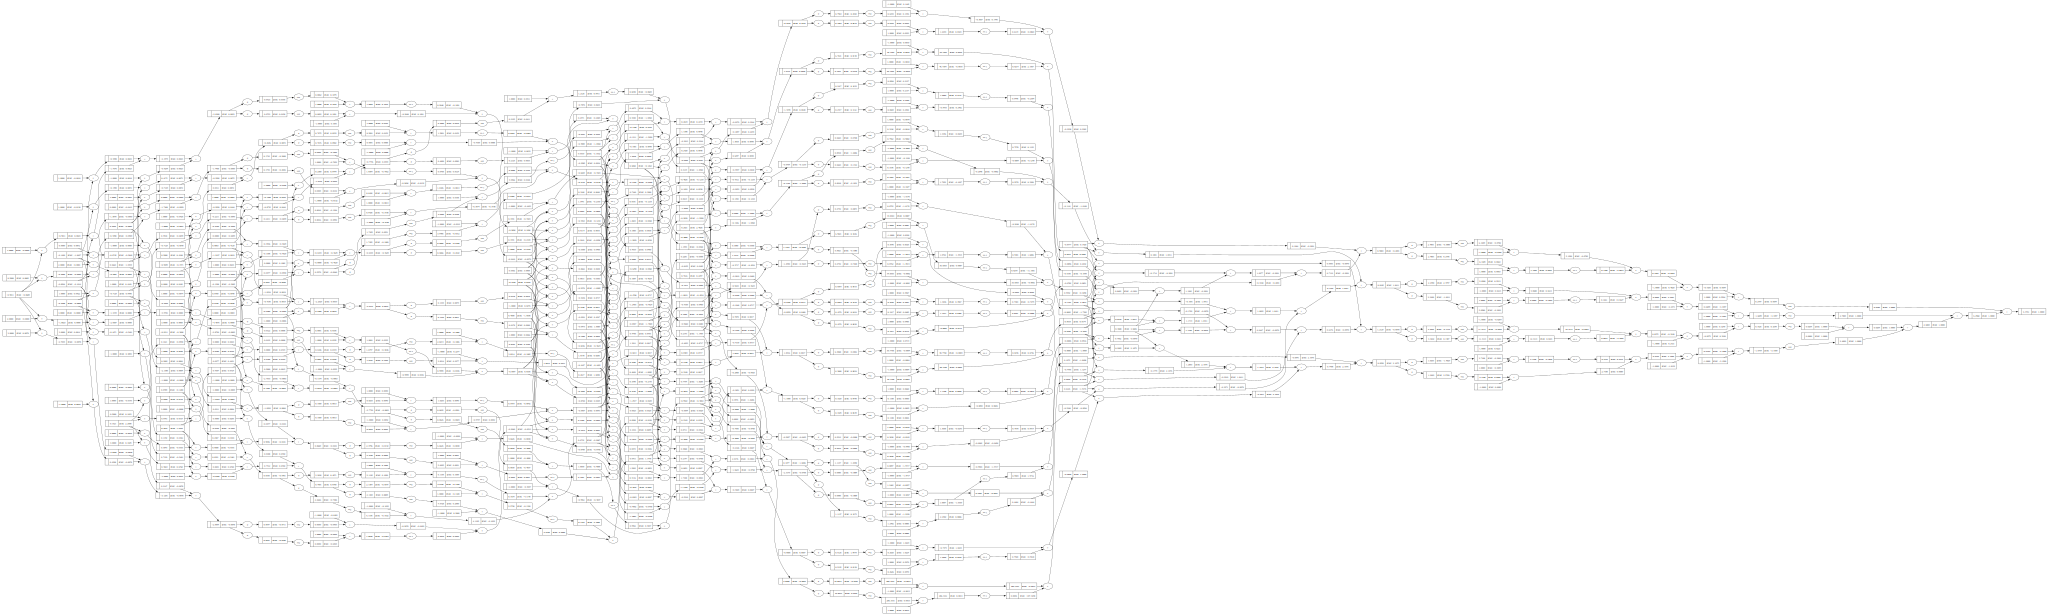

In [95]:
loss.backward()
draw_dot(loss)

In [96]:
step_size = 0.01
# for p in mlp.parameters():
p = mlp.parameters()[0]
p.grad, p.data
    

(-0.06892655764978842, -0.9011459930269137)

In [97]:
mlp.layers[0].neurons[0].weights[0].grad, mlp.layers[0].neurons[0].weights[0]

(-0.06892655764978842, Value(data=-0.9011459930269137))

In [106]:
step_size = 0.1
for k in range(20):
    y_preds = [mlp(x) for x in xs]; y_preds
    loss = sum((y-y_pred)**2 for y, y_pred in zip(ys, y_preds))
    mlp.zero_grad()
    loss.backward()
    for p in mlp.parameters():
        p.data -= step_size*p.grad
    print(k, loss.data)

0 0.004725669644804543
1 0.0046722080002911445
2 0.004619906162321727
3 0.004568727241618255
4 0.004518635887157382
5 0.0044695982071180605
6 0.004421581694642375
7 0.00437455515807229
8 0.004328488655351338
9 0.004283353432303616
10 0.004239121864526683
11 0.004195767402653813
12 0.004153264520760263
13 0.004111588667705443
14 0.004070716221217913
15 0.004030624444545114
16 0.0039912914455023825
17 0.003952696137767956
18 0.0039148182042819096
19 0.003877638062616938


In [107]:
y_preds

[Value(data=0.9769189348035515),
 Value(data=-0.9790072234152013),
 Value(data=-0.960561077202727),
 Value(data=0.963274297939104)]

In [108]:
#| hide
import nbdev; nbdev.nbdev_export()